# Optical Bubble Identification
Identify bubble size distribution using computer vision technique.

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## **Step 1** Calculate the mean frame as the background to be subtracted in the following steps.

Video opened!
(720, 1280)


True

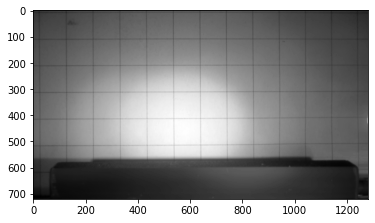

In [3]:
# Open video.
vc = cv2.VideoCapture('background.mp4')
if vc.isOpened():
    print("Video opened!")
else:
    print("Video open error!")

# Get video properties
fps = vc.get(cv2.CAP_PROP_FPS)
height = int(vc.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(vc.get(cv2.CAP_PROP_FRAME_WIDTH))
length = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))      # total number of frames

# Set background frame start time
bg_start_time = 0                                  
bg_start_frame = bg_start_time * fps; 
vc.set(cv2.CAP_PROP_POS_FRAMES, bg_start_frame)

# Read background images
ret = True
sum_frame = np.empty([height, width])       # sum all background frames
sum_num = 1                                 # added frame number                     
count = 0

while ret:
    ret, frame = vc.read()
    if count % (int(fps/40)) == 0:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        sum_frame = sum_frame + gray_frame
        sum_num += 1
    count += 1

mean_frame = sum_frame / sum_num
print(mean_frame.shape)
plt.imshow(mean_frame, cmap='gray')
cv2.imwrite('mean-background.png', mean_frame)


Sharpen image using a simple kernel. An alternate method is the unsharp masking. However, the [wiki](https://en.wikipedia.org/wiki/Unsharp_masking#Digital_unsharp_masking) says:
> The resulting image, although clearer, may be a less accurate representation of the image's subject.

In this project, the aim of image sharpening is to better obtain accurate presentation of bubbles rather than good visual performance. 



True

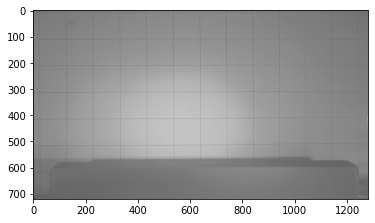

In [4]:
# Sharpen image
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])  # sharpen kernal
sharpened_background = cv2.filter2D(mean_frame, -1, kernel)
plt.imshow(sharpened_background, cmap='gray')
cv2.imwrite('sharpened-background.png', sharpened_background)


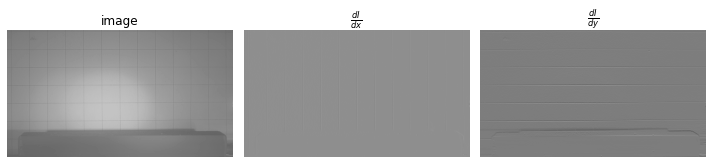

In [5]:
# Edge detection using Sobel operator
dx = cv2.Sobel(sharpened_background, cv2.CV_64F, 1, 0)
dy = cv2.Sobel(sharpened_background, cv2.CV_64F, 0, 1)

# show result of Sobel operator
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.axis('off')
plt.title('image')
plt.imshow(sharpened_background, cmap='gray')
plt.subplot(132)
plt.axis('off')
plt.imshow(dx, cmap='gray')
plt.title(r'$\frac{dI}{dx}$')
plt.subplot(133)
plt.axis('off')
plt.title(r'$\frac{dI}{dy}$')
plt.imshow(dy, cmap='gray')
plt.tight_layout()
plt.savefig('sobel-filter-result.png', dpi=600)
plt.show()

True

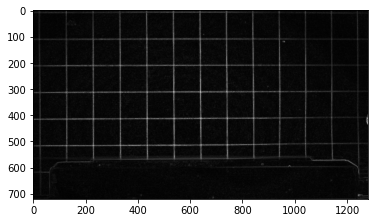

In [6]:
abs_dx = cv2.convertScaleAbs(dx)
abs_dy = cv2.convertScaleAbs(dy)
bg_edge = cv2.addWeighted(abs_dx, 0.5, abs_dy, 0.5, 0)
plt.imshow(bg_edge, cmap='gray')
cv2.imwrite('background-edge.png', bg_edge)

## **Step 2** Subtract background picture

Video opened!


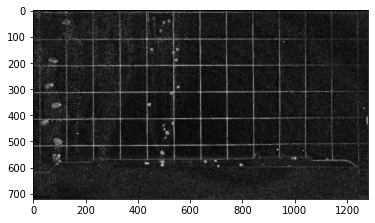

In [9]:
# read backgound image
# bg_edge = cv2.imread("background-edge.png", 0)
# plt.imshow(bg_edge, cmap='gray')

# Reopen video.
vc = cv2.VideoCapture('segment01.mp4')
if vc.isOpened():
    print("Video opened!")
else:
    print("Video open error!")
fps = vc.get(cv2.CAP_PROP_FPS)
height = int(vc.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(vc.get(cv2.CAP_PROP_FRAME_WIDTH))

bg_start_time = 10                                  
bg_start_frame = bg_start_time * fps; 
vc.set(cv2.CAP_PROP_POS_FRAMES, bg_start_frame)

# Read frame to be processed.
ret, frame = vc.read()

# Convert to gray.
gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

# Sharpen image using the previous kernel
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])  # sharpen kernal
sharpened_frame = cv2.filter2D(gray_frame, -1, kernel)

# Edge detection using Sobel operator
dx = cv2.Sobel(sharpened_frame, cv2.CV_64F, 1, 0)
dy = cv2.Sobel(sharpened_frame, cv2.CV_64F, 0, 1)
abs_dx = cv2.convertScaleAbs(dx)
abs_dy = cv2.convertScaleAbs(dy)
frame_edge = cv2.addWeighted(abs_dx, 0.5, abs_dy, 0.5, 0)
plt.imshow(frame_edge, cmap='gray')

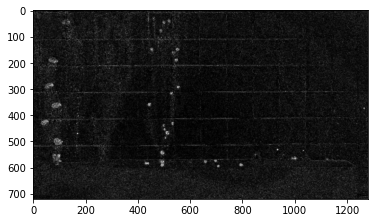

In [10]:
# Subtract background
bubble_frame = cv2.subtract(frame_edge, bg_edge)
plt.imshow(bubble_frame, cmap = 'gray')

True

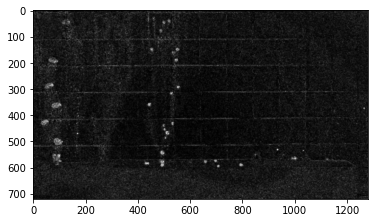

In [16]:
# Gaussian blur
bubble_frame_blur = cv2.GaussianBlur(bubble_frame, (3,3), 0)
plt.imshow(bubble_frame_blur, cmap = 'gray')
cv2.imwrite("blur-bubble.png", bubble_frame_blur)

True

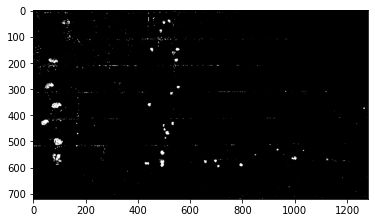

In [21]:
# Image thresholding
ret, bin_bubble_frame = cv2.threshold(bubble_frame_blur, 70, 255, cv2.THRESH_BINARY)
plt.imshow(bin_bubble_frame, cmap='gray')
cv2.imwrite('bin-bubble-frame-140.png', bin_bubble_frame)

True

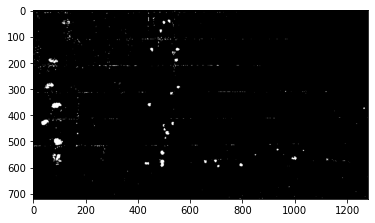

In [22]:

# Flood filling the holes of bubbles
bubble_frame_floodfill = bin_bubble_frame.copy()

# Mask size needs to be 2 pixels larger than the image.
mask = np.ones((height+2, width+2), np.uint8) * 0    
cv2.floodFill(bubble_frame_floodfill, mask, (0, 0), 255)

# Invert floodfilled image
bubble_frame_floodfill_inv = cv2.bitwise_not(bubble_frame_floodfill)
plt.imshow(bubble_frame_floodfill_inv, cmap='gray')

# Combine the two images to get the foreground
bubble_frame_result = bin_bubble_frame | bubble_frame_floodfill_inv

plt.imshow(bubble_frame_result, cmap='gray')
cv2.imwrite('bubble-frame-floodfill.png', bubble_frame_result)


True

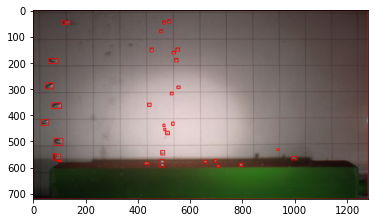

In [32]:
output = cv2.connectedComponentsWithStats(
    bubble_frame_result, connectivity=8, ltype=cv2.CV_32S)
num_labels, labels, stats, centroids = output

for this_stat in stats:
    if this_stat[4] > 40:
        cv2.rectangle(frame, (this_stat[0:2]), (this_stat[0:2]+this_stat[2:4]), 
        (255, 0, 0), 2)

plt.imshow(frame)
cv2.imwrite('bubble-detection.png', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

# draw_1 = cv2.rectangle(frame, stats[1,], (0, 255, 0), 2)
